In [38]:
import os, sys, urllib, gzip
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

In [39]:
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
import glob
import time
import os
import scipy

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [40]:
import theano
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer,DropoutLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, softmax
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

In [41]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    from lasagne.layers import Pool2DLayer
    print('Using lasagne.layers (slower)')

g_pictures_cnt=0    

Using lasagne.layers (slower)


In [42]:
region_width = 28
region_height = 28

g_split_lines = 8
g_split_cols = 8

an_min=-3
an_max=3

g_mode=3 # color mode 2 without black
g_colors=3
G_trash=1 #trashhold input picture
G_trash_learn=1 #trashhold learn picture
g_zca_mode=0 #whitening enabled
g_zca_epsilon=0.1


g_conv_num_filters = 16
g_filter_size = 3
g_pool_size = 2
g_dense_mid_size = 256
g_stride=1
g_encode_size = 32

g_classifall=2

g_ill='all'
fn_weight='conv_ae_medical200_'+g_ill+'ColorReg.pkl'
g_last_layerC2D=(((region_width-(g_filter_size-g_stride))/g_stride-(g_filter_size-g_stride))/g_stride/g_pool_size-(g_filter_size-g_stride))/g_stride/g_pool_size
g_max_epochs=500
g_dir_out='medical_out'


In [70]:
def zca_whitening_BW(matrix,epsilon = 0.1 ):
    l_h    =matrix.shape[0];
    l_w    =matrix.shape[1];
    inputs = matrix.flatten(1)
    
    inputs = inputs.reshape(1, len(inputs))
    
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    #epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     
    #ZCA Whitening matrix
    #l_res=np.clip(np.dot(ZCAMatrix, inputs)*256., a_min = 0, a_max = 255).astype('uint8')
    l_res=np.dot(ZCAMatrix, inputs)
    
    return l_res.reshape(l_h,l_w).T   #Data whitening

def zca_whitening_color(inputs,epsilon = 0.1 ):
    if len(inputs.shape)==3:
        if g_colors==1:
            gray_image = inputs
        else:
            gray_image = np.dot(inputs[..., :3], [0.299, 0.587, 0.114])
        #print (gray_image.shape)
        vv3=zca_whitening_BW(gray_image,epsilon = epsilon)
        for jjj in range(3):
            #print("jjj",jjj)
            if jjj==0:
                dd4 =vv3.reshape(1,vv3.shape[0],vv3.shape[1])
            else:    
                dd4 =np.vstack((dd4,vv3.reshape(1,vv3.shape[0],vv3.shape[1])))
            
            
            #print ("vv3",vv3.shape)
            #print ("dd4",dd4.shape)
        return np.rollaxis(dd4, 0, 3)
    
    elif len(inputs.shape)==2:        
        #print("bw_mode")
        return zca_whitening_BW(inputs,epsilon = epsilon)
    else:
        print("unk mode",inputs.shape)
        
def f_ill4fname(p_fname):
        if 'geman' in p_fname or 'dobro' in p_fname :
            return 1
        elif 'gemat' in p_fname or 'gepatom' in p_fname or  'krov' in p_fname or 'arhi' in p_fname or 'hype' in p_fname :
            return 2
        elif 'kist' in p_fname:
            return 3
        elif 'gepati' in p_fname or 'ciro' in p_fname:
            return 4
        elif 'meta' in p_fname or 'aden' in p_fname  or 'rak' in p_fname or 'karci' in p_fname or 'opuh'  in p_fname :
            return 5  
        elif 'ehin' in p_fname or 'echin' in p_fname:
            return 6  
        elif 'gepatoz' in p_fname or 'distr' in p_fname or 'asci' in p_fname:
            return 7  
        elif 'norm' in p_fname :
            return 0
        elif '-on' in p_fname :
            return 10
        elif '-off' in p_fname :
            return 11
        else:
            return 0
  
        
def f_color4fname(p_fname):
    l_illN=f_ill4fname(p_fname)
    if not not g_ill and g_ill!='all':
        if (g_ill=='meta' and l_illN==5)\
            or (g_ill=='dobro' and l_illN==1) \
            or (g_ill=='ciroz' and l_illN==4) \
            or (g_ill=='kista' and l_illN==3) \
            or (g_ill=='echino' and l_illN==6) \
            or (g_ill=='distro' and l_illN==7) \
            or (g_ill=='krov' and l_illN==2) :
            return [0,0,1]
        elif l_illN==0:
            return [-1,-1,-1]
        else:    
            return [0,0,0]
    else:
        #print('point4 '+p_fname)
        if l_illN==1:
            return [0,0,1]
        elif l_illN==2 :
            return [0,1,1]
        elif l_illN==3:
            return [1,0,1]
        elif l_illN==4:
            return [1,1,0]
        elif l_illN==6:
            return [0,1,0]
        elif l_illN==7:
            return [0,1,0]
        elif l_illN==5:
            return [1,0,0]    
        elif  l_illN==0:
            return [-1,-1,-1]
        else:
            return [1,1,1]

    

 
        
def get_pictures2np(dir_reg='pechen1_reg',dir_100='pechen224',p_width_from=0,p_width_delta=0,p_height_from=0,p_height_delta=0,p_fname=None):
    l_rw=region_width*g_split_cols
    l_rh=region_height*g_split_lines
    l_rS=l_rw*l_rh
    y_region=[]
    y_classif=[]
    x_original=[]
    fnames=[]
    global g_pictures_cnt
    l_pictures_cnt=0
    if p_fname is  None or  not p_fname:
        example_file = [f for f in glob.glob(os.path.join(dir_100,'*.*')) if ".JPG" in f or ".jpg" in f or ".png" in f or "." in f]
    else:
        example_file = [f for f in glob.glob(p_fname) ]
            
    
    for f_example in example_file:
        #im = scipy.misc.imread(f)
        f_region=os.path.join(dir_reg,os.path.basename(f_example))
        #print ('f_example='+f_example)
        if os.path.exists(f_region) or not dir_reg:
            l_col=f_color4fname(f_example)
            l_illN=f_ill4fname(f_example)
            if not not g_ill and l_col==[0,0,0] and g_ill!='all':
                continue
            if l_col==[-1,-1,-1] and g_mode==0:
                l_col=[0,0,0]
            elif l_col==[-1,-1,-1] and g_mode==2:
                l_col=[1,1,1]
                
            print (str(l_pictures_cnt)+'->  '+f_example+' '+str(l_illN),l_col)
            #y_classif.extend([l_illN])
            l_tmp=np.zeros(g_classifall)
            l_tmp[l_illN%10]=1
            y_classif.extend([l_tmp])
            l_pictures_cnt+=1
            fnames.extend([os.path.basename(f_example)])
            
            im_orig00=Image.open(f_example)
                
            if p_width_from>0 and p_width_delta==0:
                l_widthF = im_orig00.size[0]
                l_heightF = im_orig00.size[1]
                im_orig00=im_orig00.crop((int(l_widthF*p_width_from),int(l_heightF*p_height_from),l_widthF-1,l_heightF-1))
            elif p_width_from>0 and p_width_delta>0:    
                l_widthF = im_orig00.size[0]
                l_heightF = im_orig00.size[1]
                im_orig00=im_orig00.crop((l_widthF-int(l_widthF*p_width_from),0,\
                                          l_widthF+int(l_widthF*(p_width_delta-p_width_from))-1,l_heightF-1))
     
    
            if not not dir_reg:
                im_region00  = Image.open(f_region)
                if p_width_from>0 and p_width_delta==0:
                    l_widthF = im_region00.size[0]
                    l_heightF = im_region00.size[1]
                    im_region00=im_region00.crop((int(l_widthF*p_width_from),int(l_heightF*p_height_from),\
                                                  l_widthF-1,l_heightF-1))
                elif p_width_from>0 and p_width_delta>0:    
                    l_widthF = im_region00.size[0]
                    l_heightF = im_region00.size[1]
                    im_region00=im_region00.crop((l_widthF-int(l_widthF*p_width_from),0,\
                                                  l_widthF+int(l_widthF*(p_width_delta-p_width_from))-1,l_heightF-1))
            else: 
                im_region00  = im_orig00

            
            if g_zca_mode==1:
                im_orig=Image.fromarray(zca_whitening_color(np.array(im_orig00),epsilon = g_zca_epsilon))
                im_region=Image.fromarray(zca_whitening_color(np.array(im_region00),epsilon = g_zca_epsilon ))
            else:
                im_orig=im_orig00
                im_region=im_region00
                
            l_im_orig3 = np.array(im_orig.resize((l_rw, l_rh), Image.BILINEAR)).reshape(l_rS,-1) # linear interpolation in a 2x2 environment
            l_im_reg3  = np.array(im_region.resize((l_rw, l_rh), Image.BILINEAR)).reshape(l_rS,-1)     # linear interpolation in a 2x2 environment
            im4 = []
            if l_im_orig3.shape[1]==1:
                l_im_orig0=l_im_orig3
                l_im_orig3=np.hstack((l_im_orig3,l_im_orig0))
                l_im_orig3=np.hstack((l_im_orig3,l_im_orig0))
            if l_im_reg3.shape[1]==1:
                l_im_reg0=l_im_reg3
                l_im_reg3=np.hstack((l_im_reg3,l_im_reg0))
                l_im_reg3=np.hstack((l_im_reg3,l_im_reg0))

            for pix in range(l_rS) :
                d00=[0,0,0]
                if (g_mode==0 or g_mode==1) and ( l_im_reg3[pix][0]>G_trash_learn or l_im_reg3[pix][0]> l_im_orig3[pix][0]) and (l_im_orig3[pix][0]>=G_trash):
                    d00=[l_im_orig3[pix][0]*l_col[0],l_im_orig3[pix][0]*l_col[1],l_im_orig3[pix][0]*l_col[2]]
                elif g_mode==2  and (l_im_orig3[pix][0]>=G_trash or l_im_orig3[pix][1]>=G_trash or l_im_orig3[pix][2]>=G_trash):
                    if (l_im_reg3[pix][0]>G_trash_learn or l_im_reg3[pix][0]> l_im_orig3[pix][0]):
                        d00=[l_im_orig3[pix][0]*l_col[0],l_im_orig3[pix][0]*l_col[1],l_im_orig3[pix][0]*l_col[2]]
                    else:
                        d00=[l_im_orig3[pix][0]/4,l_im_orig3[pix][0]/4,l_im_orig3[pix][0]/4]
                elif g_mode==3:
                    if l_col==[-1,-1,-1]:
                        d00=[l_im_orig3[pix][0]/2,l_im_orig3[pix][0]/2,l_im_orig3[pix][0]/2]
                    elif (l_im_orig3[pix][0]>=G_trash or l_im_orig3[pix][1]>=G_trash or l_im_orig3[pix][2]>=G_trash):
                        if (l_im_reg3[pix][0]>G_trash_learn or l_im_reg3[pix][0]> l_im_orig3[pix][0]):
                            d00=[l_im_orig3[pix][0]*l_col[0],l_im_orig3[pix][0]*l_col[1],l_im_orig3[pix][0]*l_col[2]]
                        else:
                            d00=[l_im_orig3[pix][0]/2,l_im_orig3[pix][0]/2,l_im_orig3[pix][0]/2]
                       
                if g_colors==1:
                    im4.extend([d00[0]])    
                else:    
                    im4.extend(d00)    
                
            y_region.extend([im4])
            if l_im_orig3.shape[1]==1:
                d1=np.array(zip(l_im_orig3,l_im_orig3  ,l_im_orig3))
            else:
                d1=np.array(l_im_orig3)
            if g_colors==1:
                x_original.extend([d1[:,0].reshape(-1,1)])
                #c=b[:,1].reshape(-1,1)            
            else:
                x_original.extend([d1])
        else:
            print (" no file "+f_example)
    if p_fname is None or  not p_fname:        
        g_pictures_cnt=g_pictures_cnt        
    return fnames,np.array(x_original).reshape(l_pictures_cnt,l_rh,l_rw,-1),\
           np.array(y_region).reshape(l_pictures_cnt,l_rh,l_rw,-1),\
           np.array(y_classif, dtype=np.float32).reshape(l_pictures_cnt,-1)

# rotate image and split it for n tiles        
def get_transformedImgages(P_images,p_angle=1):
    destImages=[]
    for ii1 in range(P_images.shape[0]):
        if g_colors==1:
            l_image=np.uint8(P_images[ii1]).reshape(P_images.shape[1],P_images.shape[2])
        else:
            l_image=np.uint8(P_images[ii1])
        if p_angle!=0:
            im21= np.array(Image.fromarray(l_image).rotate(p_angle))
        else:
            im21= np.array(Image.fromarray(l_image))
        if (g_split_lines<2 and g_split_cols<2):
            destImages.extend([im21])
        else:
            for dy in range(g_split_lines):
                for dx in range(g_split_cols):
                    y1=dy*region_height
                    x1=dx*region_width
                    y2=y1+region_height
                    x2=x1+region_width
                    im22=im21[y1:y2,x1:x2]
                    destImages.extend([im22])



    destImages=np.array(destImages)
    if g_colors==1:
        return destImages.reshape(destImages.shape[0],destImages.shape[1],destImages.shape[2],1)    
    else:
        return destImages    

def get_transformedData(p_x_orig,p_y_reg,p_y_classif):
    l_X=[]
    l_y=[]
    l_y_classif=[]
    for an in np.arange(an_min,an_max):
        rot_orig=get_transformedImgages(p_x_orig,p_angle=an)
        for ii1 in range(rot_orig.shape[0]):
            d0=rot_orig[ii1]
            if g_colors==1:
                d1=np.rollaxis((d0)/256., 2, 0)
            else:
                d1=np.rollaxis((d0)/256., 2, 0)
            l_X.extend([d1])
    
        rot_reg =get_transformedImgages(p_y_reg,p_angle=an)
        for ii1 in range(rot_reg.shape[0]):
            d0=rot_reg[ii1]
            d1=np.rollaxis((d0)/256., 2, 0)
            l_y.extend([d1])
        
        for ii1 in range(p_y_classif.shape[0]):
            l_y_classif.extend([p_y_classif[ii1]])
        

    return np.asarray(l_X, dtype=np.float32),np.asarray(l_y, dtype=np.float32),np.asarray(l_y_classif, dtype=np.float32)


def getNTile(p_NN=0,p_dx=0,p_dy=0,p_angle=0):
    #print ('getNTile p_NN,p_dx,p_dy,p_angle,g_pictures_cnt ->',p_NN,p_dx,p_dy,p_angle,g_pictures_cnt)
    l_angleIdx=p_angle-an_min
    l_GlobalOffset=(l_angleIdx)*g_pictures_cnt*g_split_lines
    #print('l_GlobalOffset',l_GlobalOffset)

    l_NNOffset=p_NN*g_split_lines
    l_YOffset=p_dy*g_split_cols ## ???
    l_XOffset=p_dx
    return l_GlobalOffset+l_NNOffset+l_YOffset+l_XOffset


def GetWholeIdxes(p_NN=0,p_angle=0):
    idxes=[]
    for dy in range(g_split_lines):
        for dx in range(g_split_cols):
            idxes.extend([getNTile(p_NN=p_NN,p_dx=dx,p_dy=dy,p_angle=p_angle)])
    return np.array(idxes)             

def GetWholeFrames(p_Xcolor,p_nn,p_angle=0):
    idxes1=GetWholeIdxes(p_NN=p_nn,p_angle=p_angle)
    #print('idxes1 ',idxes1)
    X_input=[]
    for idx in idxes1:
        X_input.extend(p_Xcolor[idx])
    X_input222=np.array(X_input).reshape(-1,g_colors,  region_height,region_width)
    return X_input222





def PredictByWholeImg(p_Xcolor,p_nn,p_angle=0,p_net=ae):
    X_input2=GetWholeFrames(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    X_out22 = p_net.predict(X_input2).reshape(-1,g_colors, region_width, region_height)
    return X_out22 


def AssembleImage(p_FramesImage):
    #print("p_FramesImage=",p_FramesImage.shape) 
    #l_region_width =p_FramesImage.shape[2]
    l_region_width =p_FramesImage.shape[3]
    #print('l_region_width =',l_region_width)
    #l_region_height=p_FramesImage.shape[3]
    l_region_height=p_FramesImage.shape[2]
    #print('l_region_height =',l_region_height)
    l_colors=p_FramesImage.shape[1]
    #print("l_colors=",l_colors) 
    
    if (l_colors==3):
        dst_im22 = Image.new("RGB", (g_split_cols*l_region_width,g_split_lines*l_region_height), "red" )
    elif (l_colors==1):    
        dst_im22 = Image.new("L", (g_split_cols*l_region_width,g_split_lines*l_region_height), (0) )
    elif (l_colors==4):    
        dst_im22 = Image.new("RGBA", (g_split_cols*l_region_width,g_split_lines*l_region_height), "blue" )

    for dy in range(g_split_lines):
        for dx in range(g_split_cols):
            #print('dy dx',dy,dx)
            im1=np.uint8(np.rollaxis(p_FramesImage[dy*g_split_cols+dx], 0, 3)*256.)
            #print('im1=',im1.shape)
            im1= np.clip(im1, a_min = 0, a_max = 255)
            im1  = im1.astype('uint8')
            if (l_colors==1):
                #rot=Image.fromarray(im1.reshape(l_region_width,l_region_height))
                rot=Image.fromarray(im1.reshape(l_region_height,l_region_width))
            else:
                rot=Image.fromarray(im1)
            dst_im22.paste( rot, (dx*l_region_width, dy*l_region_height)) 
    return np.array(dst_im22)  

def GetPicture(p_Xcolor,p_nn,p_angle=0):
    #print ('GetPicture.p_Xcolor',p_Xcolor.shape)
    X_input2=GetWholeFrames(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    dst_im22=AssembleImage(X_input2)
    return dst_im22  

def PredictByWholeImgFull(p_Xcolor,p_nn,p_angle=0):
    X_out22 = PredictByWholeImg(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    dst_im22=AssembleImage(X_out22)
    return dst_im22  





def MergePredict_Original(p_original,p_predict):
    l_rw=region_width*g_split_cols
    l_rh=region_height*g_split_lines
    l_rS=l_rw*l_rh
    l_colors=p_original.shape[2]
    if g_mode==1:
        l_blend_img = Image.blend(Image.fromarray(p_original.astype('uint8')), 
                             Image.fromarray(p_predict), 0.5)

        return np.array(l_blend_img)
    else:
        l_region_width=p_original.shape[0]
        l_region_height=p_original.shape[1]
        im11 = p_original.reshape(l_region_width*l_region_height,-1) 
        im3  = p_predict.reshape(l_region_width*l_region_height,-1) 
    
        im4=[]
        for pix in range(l_rS) :
            if im3[pix][0]>10   :
                if l_colors==1:
                    im4.extend([im11[pix][0],im11[pix][0]/4,im11[pix][0]/4])
                else:    
                    im4.extend([im11[pix][0],im11[pix][1]/4,im11[pix][2]/4])
            else:
                if l_colors==1:
                    im4.extend([im11[pix][0],im11[pix][0],im11[pix][0]])
                else:    
                    im4.extend(im11[pix])
        if l_colors==1:
            return  np.array(im4).reshape(p_original.shape[0],p_original.shape[1],3).astype('uint8')        
        else:    
            return  np.array(im4).reshape(p_original.shape[0],p_original.shape[1],p_original.shape[2]).astype('uint8')        


def get_layer_by_name(net, name):
    for i, layer in enumerate(net.get_all_layers()):
        if layer.name == name:
            return layer, i
    return None, None


def print_layers(net):
    for i, layer in enumerate(net.get_all_layers()):
        print( layer.name, i)

def encode_input(encode_layer, X):
    return get_output(encode_layer, inputs=X).eval()

def predictLayer(p_net,p_layerName,p_Xcolor,p_nn,p_angle=0,p_layerFrom=0,p_layers=4):
    l_encode_layer, l_encode_layer_index = get_layer_by_name(p_net, p_layerName)
    l_X_input222=GetWholeFrames(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    l_X_encoded = encode_input(l_encode_layer, l_X_input222)
    print ('predictLayer '+p_layerName+' ',l_X_encoded.shape)
    l_X_encoded2=l_X_encoded[:,p_layerFrom:p_layerFrom+p_layers,:,:]
    l_res=AssembleImage(l_X_encoded2)
    return l_res 
    

def predictLayersToFile(p_net,p_layerName,p_Xcolor,p_nn,p_angle=0,N_epoch=1,diroutput=g_dir_out):
    l_encode_layer, l_encode_layer_index = get_layer_by_name(p_net, p_layerName)
    l_X_input222=GetWholeFrames(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    l_X_encoded = encode_input(l_encode_layer, l_X_input222)
    dst_im44 = Image.new("L", (g_split_cols*l_X_encoded.shape[2]*l_X_encoded.shape[1],g_split_lines*l_X_encoded.shape[3]), (0) )
    l_name='layer_'+p_layerName+'_'+str(p_nn)+'_'+str(N_epoch)+'.png'
    f_outf=os.path.join(g_dir_out,os.path.basename(l_name))
    

    for l_feature in range(l_X_encoded.shape[1]):
        l_X_encoded2=l_X_encoded[:,l_feature:l_feature+1,:,:]
        l_res=AssembleImage(l_X_encoded2)
        l_ResIm=Image.fromarray(l_res)
        dst_im44.paste( l_ResIm, (l_feature*g_split_cols*l_X_encoded.shape[2], 0)) 
    dst_im44.save(f_outf)
    
    #l_pred_out=PredictByWholeImgFull(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    #l_ResIm=Image.fromarray(l_res)
    #l_name='layer_predict_'+str(p_nn)+'_'+str(N_epoch)+'.png'
    #f_outf=os.path.join(g_dir_out,os.path.basename(l_name))
    #l_ResIm.save(f_outf)
    
    #print('saved '+f_outf)
    return np.array(dst_im44)  


def f_solve(p_fname,p_net):
    fnames3,x_original13,y_region13,y_classif13=get_pictures2np(dir_100='conduk',dir_reg='',p_width_from=0.7,p_fname=p_fname)
    #print ("loaded shape:",x_original13.shape,y_region13.shape)
    l_X3=[]
    l_rot_orig=get_transformedImgages(x_original13,p_angle=0)
    for ii1 in range(l_rot_orig.shape[0]):
            d1=np.rollaxis((l_rot_orig[ii1])/256., 2, 0)
            l_X3.extend([d1])
    l_X31=np.asarray(l_X3, dtype=np.float32)
    #print ("transformed shape:",l_X31.shape)
    l_preidict=p_net.predict(l_X31.reshape(1,l_X31.shape[1],l_X31.shape[2],l_X31.shape[3]))
    #print ("l_preidict:",l_preidict,l_preidict.shape[1])
    if l_preidict.shape[1]==g_classifall:
        l_preidict2=np.argmax(l_preidict)
        print ("l_preidict2:",np.argmax(l_preidict))
    else:
        l_preidict2=None
        print ("l_preidict:",l_preidict,l_preidict.shape[1])

        
        
    
    return l_X31,l_preidict,l_preidict2


    

In [45]:
def load_pechen():
    fnames,x_original1,y_region1,y_classif1=get_pictures2np(dir_reg='pechen1_reg',dir_100='pechen224')
    print ("loaded shape:",x_original1.shape,y_region1.shape)
    Xcolor1,ycolor1,yclassif1=get_transformedData(p_x_orig=x_original1,p_y_reg=y_region1,p_y_classif=y_classif1)
    print ("transformed shape:",Xcolor1.shape,ycolor1.shape,yclassif1.shape)
    
    X_out1 = ycolor1.reshape((Xcolor1.shape[0], -1))
    print (X_out1.shape)
    #print(fnames)
    return Xcolor1,X_out1,Xcolor1,ycolor1,fnames,x_original1,y_region1,y_classif1,yclassif1


In [46]:
def load_conduk():
    fnames,x_original1,y_region1,y_classif1=get_pictures2np(dir_100='conduk',dir_reg='',p_width_from=0.7)
    print ("loaded shape:",x_original1.shape,y_region1.shape)
    Xcolor1,ycolor1,yclassif1=get_transformedData(p_x_orig=x_original1,p_y_reg=y_region1,p_y_classif=y_classif1)
    print ("transformed shape:",Xcolor1.shape,ycolor1.shape,yclassif1.shape)
    
    X_out1 = ycolor1.reshape((Xcolor1.shape[0], -1))
    print (X_out1.shape)
    #print(fnames)
    return Xcolor1,X_out1,Xcolor1,ycolor1,fnames,x_original1,y_region1,y_classif1,yclassif1


In [47]:
region_width = 280
region_height = 100
g_split_lines = 1
g_split_cols = 1

an_min=-5
an_max=5

g_mode=3 # color mode 2 without black
g_colors=3
G_trash=1 #trashhold input picture
G_trash_learn=1 #trashhold learn picture
g_zca_mode=0 #whitening enabled
g_zca_epsilon=0.1


g_conv_num_filters = 16
g_filter_size = 3
g_pool_size = 2
g_dense_mid_size = 256
g_stride=1
g_encode_size = 32
g_ill='all'
fn_weight='conduk.pkl'
g_last_layerC2D=(((region_width-(g_filter_size-g_stride))/g_stride-(g_filter_size-g_stride))/g_stride/g_pool_size-(g_filter_size-g_stride))/g_stride/g_pool_size
g_max_epochs=500
g_dir_out='canduk_out'

Xcolor,X_out,Xcolor_test,ycolor,fnames,x_original,y_region,y_classif0,y_classif=load_conduk()
#fnames,x_original1,y_region1,y_classif1=get_pictures2np(dir_100='conduk',dir_reg='',p_width_from=0.5)
#plt.figure(figsize=(15,15)) 
#sub4 = plt.subplot(1, 3, 1)
#plt.imshow(x_original1[nn], cmap='gray')
#sub4 = plt.subplot(1, 3, 2)
#plt.imshow(y_region1[nn], cmap='gray')


#nt ("loaded shape:",x_original1.shape,y_region1.shape)


0->  conduk/ac-on40.jpg 10 [1, 1, 1]
1->  conduk/ac-off-03.jpg 11 [1, 1, 1]
2->  conduk/ac-off26.jpg 11 [1, 1, 1]
3->  conduk/ac-on7.jpg 10 [1, 1, 1]
4->  conduk/ac-off21.jpg 11 [1, 1, 1]
5->  conduk/ac-off.png 11 [1, 1, 1]
6->  conduk/ac-off5.jpg 11 [1, 1, 1]
7->  conduk/ac-off6.jpg 11 [1, 1, 1]
8->  conduk/ac-off.3png 11 [1, 1, 1]
9->  conduk/ac-on.png 10 [1, 1, 1]
10->  conduk/ac-off24.jpg 11 [1, 1, 1]
11->  conduk/ac-off34.jpg 11 [1, 1, 1]
12->  conduk/ac-off40.jpg 11 [1, 1, 1]
13->  conduk/ac-off-01.jpg 11 [1, 1, 1]
14->  conduk/ac-off22.jpg 11 [1, 1, 1]
15->  conduk/ac-on4.jpg 10 [1, 1, 1]
16->  conduk/ac-off12.jpg 11 [1, 1, 1]
17->  conduk/ac-on-01.jpg 10 [1, 1, 1]
18->  conduk/ac-on.-03jpg 10 [1, 1, 1]
19->  conduk/ac-off9.jpg 11 [1, 1, 1]
20->  conduk/ac-off32.jpg 11 [1, 1, 1]
21->  conduk/ac-on-03.jpg 10 [1, 1, 1]
22->  conduk/ac-on.jpg 10 [1, 1, 1]
23->  conduk/ac-on6.jpg 10 [1, 1, 1]
24->  conduk/ac-off18.jpg 11 [1, 1, 1]
25->  conduk/ac-off33.jpg 11 [1, 1, 1]
26->  conduk/

In [ ]:
region_width = 28
region_height = 28
g_split_lines = 8
g_split_cols = 8

an_min=-3
an_max=3

g_mode=3 # color mode 2 without black
g_colors=3
G_trash=1 #trashhold input picture
G_trash_learn=1 #trashhold learn picture
g_zca_mode=0 #whitening enabled
g_zca_epsilon=0.1


g_conv_num_filters = 16
g_filter_size = 3
g_pool_size = 2
g_dense_mid_size = 256
g_stride=1
g_encode_size = 32
g_ill='all'
fn_weight='conv_ae_medical200_'+g_ill+'ColorReg.pkl'
g_last_layerC2D=(((region_width-(g_filter_size-g_stride))/g_stride-(g_filter_size-g_stride))/g_stride/g_pool_size-(g_filter_size-g_stride))/g_stride/g_pool_size
g_max_epochs=500
g_dir_out='medical_out'

Xcolor,X_out,Xcolor_test,ycolor,fnames,x_original,y_region,y_classif0,y_classif=load_pechen()


(100, 280, 3)


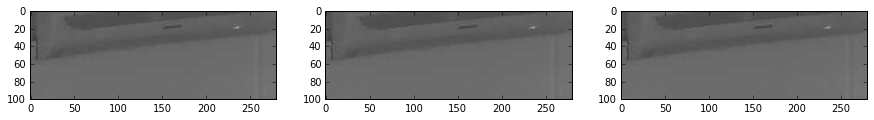

In [48]:
nn=2
plt.figure(figsize=(15,15)) 
im_in=GetPicture(Xcolor,p_nn=nn,p_angle=0)
im_learn=GetPicture(X_out,p_nn=nn)
print(im_in.shape)
if g_colors==1:
    sub4 = plt.subplot(1, 3, 1)
    plt.imshow(np.array(im_in), cmap='gray')
    sub4 = plt.subplot(1, 3, 2)
    plt.imshow(np.array(im_learn), cmap='gray')
else:
    sub4 = plt.subplot(1, 3, 1)
    plt.imshow(np.array(im_in))
    sub4 = plt.subplot(1, 3, 2)
    plt.imshow(np.array(im_learn))
sub4 = plt.subplot(1, 3, 3)
plt.imshow(x_original[nn], cmap='gray')


In [49]:
#http://danielnouri.org/notes/category/deep-learning/
#import theano
#def float32(k):
#    return np.cast['float32'](k)
#https://www.kaggle.com/askrotov/predict-west-nile-virus/simple-lasagne-nn/run/13201
from sklearn.metrics import log_loss

class AdjustVariable(object):
    def __init__(self, variable, target, half_life=10):
        self.variable = variable
        self.target = target
        self.half_life = half_life
    def __call__(self, nn, train_history):
        delta = self.variable.get_value() - self.target
        delta /= 2**(1.0/self.half_life)
        self.variable.set_value(np.float32(self.target + delta))

class LinearAdjustVariable(object):
    """
        Adjusts a variable after each epoch, e.g. learning_rate or momentum
        name : name of the variable to update
        start : start value for update
        stop : stop value for update
    """
    def __init__(self, name, start=0.1, stop=0.001):
        self.name = name
        self.start = start
        self.stop = stop

        # TODO: make custom stepfuction, exponential etc.
        self.step_function = None

    def __call__(self, nn, train_history):
        epoch = train_history[-1]['epoch']
        new_value = self.start
        stepsize = 0.4 * (self.start - self.stop) / nn.max_epochs
        if self.start < 0.1:
            new_value -= stepsize * epoch  # np.float32(self.ls[epoch-1])
            new_value = max(new_value, self.stop)
        else:
            new_value += stepsize * epoch
            new_value = min(new_value, self.stop)

        new_value = np.float32(new_value)
        #print('im here '+self.name)
        getattr(nn, self.name).set_value(new_value)


class EarlyStopper(object):
    """
        Stops learning if there was no improvement for N iterations
        max_iterations : number of iterations to have no improvement in a row
                         before stopping
    """
    def __init__(self, max_iterations=10):
        self.max_iterations = max_iterations
        self.best_iteration_score = 10000
        self.best_iteration = 0

    def __call__(self, nn, train_history):
        if self.best_iteration_score > train_history[-1]['valid_loss']:
            self.best_iteration_score = train_history[-1]['valid_loss']
            self.best_iteration = len(train_history)

        if len(train_history) - self.best_iteration >= self.max_iterations:
            nn.max_epochs = train_history[-1]['epoch']


class CustomValidationSet(object):
    """
        Pass a custom validation set and a metric, standart is log_loss
        validation_items: pass items in the form [('name1', [test_x, test_y]),
                                                  ('name2',...)]]
    """
    def __init__(self, validation_items=None, metric=log_loss):
        self.validation_items = validation_items
        self.metric = metric
    def __call__(self, nn, train_history):
        if self.validation_items is None:
            return
        for name, data in self.validation_items:
            data_x, data_y = data
            print('Validating {name}: {score}'.format(
                name=name, score=self.metric(data_y, nn.predict_proba(data_x))))


class TrainRatioStopper(object):
    """
        Stops learning if train_loss/validation_loss falls below a certain ratio
        stop_ratio : the train_loss/validation_loss ratio to stop training
    """
    def __init__(self, stop_ratio=0.8):
        self.stop_ratio = stop_ratio
    def __call__(self, nn, train_history):
        ratio = train_history[-1]['train_loss'] / \
            train_history[-1]['valid_loss']
        if ratio < self.stop_ratio:
            nn.max_epochs = train_history[-1]['epoch']


class BestIterationSaver(object):
    """
        Saves the weights for the best iteration
        name : name of the best iteration weights file
        delayed_start : number of iterations to wait before starting to save
        verbose : print a logmessage when saving
    """
    def __init__(self, name='best_iteration.weights', delayed_start=10, verbose=0):
        self.best_score = None
        self.best_weights = None
        self.delayed_start = delayed_start
        self.filename = name
        self.verbose = verbose

    def __call__(self, nn, train_history):
        if len(train_history) < self.delayed_start:
            return
        if self.best_score is None or train_history[-1]['valid_loss'] < self.best_score:
            if self.verbose:
                print('Saving to {filename}'.format(filename=self.filename))
            self.best_score = train_history[-1]['valid_loss']
            nn.save_weights_to(self.filename)

            
class Save4Animate(object):
    """
        Saves the weights for the best iteration
        name : name of the best iteration weights file
        delayed_start : number of iterations to wait before starting to save
        verbose : print a logmessage when saving
    """
    def __init__(self, layer='deconv2D2',prefix='animate', verbose=1,p_nn=1,p_angle=0):
        self.prefix = prefix
        self.verbose = verbose
        self.c_layer =layer
        self.N_image=p_nn
        self.angle=p_angle

    def __call__(self, nn, train_history):
        if self.verbose:
            print('Saving for animate  {layer} {epoch}'.format(layer=self.c_layer, epoch=len(train_history)))
        lll=predictLayersToFile(p_net=nn,p_layerName=self.c_layer,p_Xcolor=Xcolor,p_nn=self.N_image,p_angle=self.angle,N_epoch=len(train_history))


class MyOnbatch(object):
    """
        Saves the weights for the best iteration
        name : name of the best iteration weights file
        delayed_start : number of iterations to wait before starting to save
        verbose : print a logmessage when saving
    """
    def __init__(self, layer='deconv2D2',prefix='animate', verbose=1,p_nn=1,p_angle=0):
        self.prefix = prefix
        self.verbose = verbose
        self.c_layer =layer
        self.N_image=p_nn
        self.angle=p_angle

    def __call__(self, nn, train_history):
        print ('its batch iterate ')
        
        
            
        
conv_num_filters = g_conv_num_filters
filter_size = g_filter_size
pool_size = g_pool_size
encode_size = g_encode_size
dense_mid_size = g_dense_mid_size
stride=g_stride
learning_rate = theano.shared(np.float32(0.1))
momentum =   theano.shared(np.float32(0.975))



layers_classif = [
    (InputLayer, {'name': 'input1','shape': (None, Xcolor.shape[1], Xcolor.shape[2], Xcolor.shape[3])}), 
    (Conv2DLayerFast, {'name': 'conv2D1','num_filters': 32, 'filter_size': (5,5), \
                       "nonlinearity":rectify}),
    (MaxPool2DLayerFast, {'name': 'maxpool1','pool_size': (2, 2)}),
    (Conv2DLayerFast, {'name': 'conv2D2','num_filters': 32, 'filter_size': (5,5), \
                       "nonlinearity": rectify}),
    (MaxPool2DLayerFast, {'name': 'maxpool2','pool_size': (2, 2)}),
    (DropoutLayer, {'name': 'dropout1',"p": .5}), 
    (DenseLayer, {'name': 'hidden1','num_units': 256, "nonlinearity": rectify}),
    (DropoutLayer, {'name': 'dropout2',"p": .5}), 
    (DenseLayer, {'name': 'output1','num_units': g_classifall, "nonlinearity": softmax}),
]

pad_in = 'valid'
pad_out = 'full'

layers = [
    (InputLayer, {'name': 'input','shape': (None, Xcolor.shape[1], Xcolor.shape[2], Xcolor.shape[3])}), 
    (Conv2DLayerFast, {'name': 'conv2D1','num_filters': conv_num_filters, 'filter_size': filter_size, 'stride': stride,  'pad': pad_in}),
    (Conv2DLayerFast, {'name': 'conv2D2','num_filters': conv_num_filters, 'filter_size': filter_size, 'stride': stride, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'name': 'maxpool1','pool_size': pool_size}),
    #(Pool2DLayer, {'name': 'maxpool1','pool_size': pool_size,'mode': 'average_exc_pad'}),
    (Conv2DLayerFast, {'name': 'conv2D3','num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'stride': stride, 'pad': pad_in}),
    #(Pool2DLayer, {'name': 'maxpool2','pool_size': pool_size,'mode': 'average_exc_pad'}),
    (MaxPool2DLayerFast, {'name': 'maxpool2','pool_size': pool_size}),
    (ReshapeLayer, {'name': 'reshapei','shape': (([0], -1))}),
    (DenseLayer, {'name': 'encode_midi','num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'name': 'encode_mido','num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode_dense','num_units': 2*conv_num_filters*g_last_layerC2D* g_last_layerC2D}),
    (ReshapeLayer, {'name': 'reshapeo','shape': (([0], 2*conv_num_filters, g_last_layerC2D, g_last_layerC2D))}),
    (Upscale2DLayer, {'name': 'unpool2','scale_factor': pool_size}),
    (Conv2DLayerSlow, {'name': 'deconv2D3','num_filters': conv_num_filters, 'filter_size': filter_size, 'stride': stride, 'pad': pad_out}),
    (Upscale2DLayer, {'name': 'unpool1','scale_factor': pool_size}),
    (Conv2DLayerSlow, {'name': 'deconv2D2','num_filters': conv_num_filters, 'filter_size': filter_size, 'stride': stride, 'pad': pad_out}),
    (Conv2DLayerSlow, {'name': 'deconv2D1','num_filters': g_colors, 'filter_size': filter_size, 'stride': stride, 'pad': pad_out}),
    (ReshapeLayer, {'name': 'output','shape': (([0], -1))}),
]



ae = NeuralNet(
    layers=layers,
    max_epochs=g_max_epochs,
    
    update=nesterov_momentum,
    update_learning_rate=learning_rate,
    #update_learning_rate=0.025,
    #update_momentum=0.975,
    update_momentum=momentum,
    on_epoch_finished = [
        #LinearAdjustVariable('update_learning_rate', start=0.05, stop=0.0001),
        #LinearAdjustVariable('update_momentum', start=0.9, stop=0.999),
        #TrainRatioStopper(0.8),
        #EarlyStopper(),
        #BestIterationSaver(verbose=0),
        Save4Animate(layer='conv2D1',prefix='animate', verbose=0,p_nn=4,p_angle=0),
        Save4Animate(layer='conv2D2',prefix='animate', verbose=0,p_nn=4,p_angle=0),
        Save4Animate(layer='conv2D3',prefix='animate', verbose=0,p_nn=4,p_angle=0),
        Save4Animate(layer='deconv2D3',prefix='animate', verbose=0,p_nn=4,p_angle=0),
        Save4Animate(layer='deconv2D2',prefix='animate', verbose=0,p_nn=4,p_angle=0),
        Save4Animate(layer='deconv2D1',prefix='animate', verbose=0,p_nn=4,p_angle=0)
        
        ],
    
    #on_batch_finished= [
    #    MyOnbatch(layer='deconv2D1',prefix='animate', verbose=0,p_nn=4,p_angle=0)
    #    ],

    regression=True,
    verbose=1
)


ae_classif = NeuralNet(
    layers=layers_classif,
    max_epochs=g_max_epochs,
    update=nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.9,
    on_epoch_finished = [
        Save4Animate(layer='conv2D1',prefix='animate', verbose=0,p_nn=2,p_angle=0),
        Save4Animate(layer='conv2D2',prefix='animate', verbose=0,p_nn=2,p_angle=0),
        BestIterationSaver(verbose=1,name='best_conduk.weights', delayed_start=50),
        ],
    regression=True,
    verbose=1
)


# Neural Network with 12103842 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input1    3x100x280
  1  conv2D1   32x96x276
  2  maxpool1  32x48x138
  3  conv2D2   32x44x134
  4  maxpool2  32x22x67
  5  dropout1  32x22x67
  6  hidden1   256
  7  dropout2  256
  8  output1   2

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.27004       0.22785      1.18517  34.92s
      2       0.21963       0.21892      1.00324  34.99s
      3       0.21231       0.22136      0.95915  34.85s
      4       0.21703       0.22288      0.97375  34.82s
      5       0.21551       0.22137      0.97353  34.83s
      6       0.21447       0.21883      0.98009  34.87s
      7       0.21585       0.21646      0.99717  34.83s
      8       0.20451       0.21565      0.94832  34.82s
      9       0.20577       0.21496      0.95722  34.91s
     10       0.19827       0.21389      0.92697  34

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

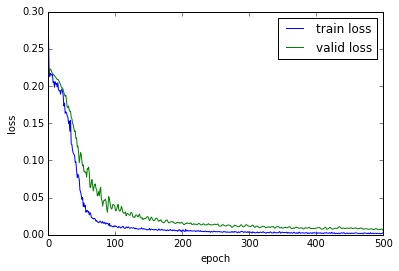

In [50]:
#print(y_classif)
g_max_epochs=1000

ae_classif.fit(Xcolor,y_classif)
pickle.dump(ae, open(fn_weight,'wb'))
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae_classif)

0->  conduk/valid/ac-off.jpg 11 [1, 1, 1]
l_preidict2: 1


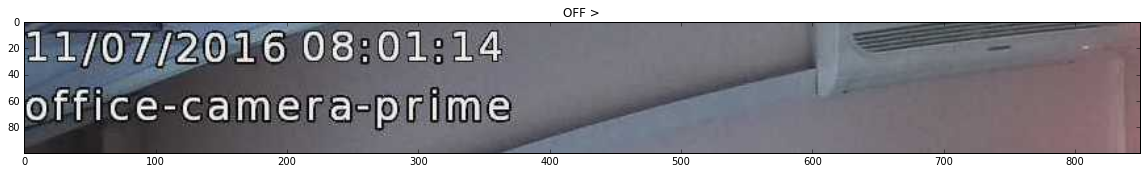

In [76]:
l_fname='conduk/valid/ac-off.jpg'
x11,pred11,pred11a=f_solve(p_fname=l_fname,p_net=ae_classif)
plt.figure(figsize=(20,20)) 
im_in=Image.open(l_fname)
sub1 = plt.subplot(1, 1,1)
dd='OFF' if pred11a==1 else 'ON'
if g_colors==1:
    plt.imshow(im_in,  cmap='gray')
else:
    plt.imshow(im_in)
sub1.set_title(dd+' >')


In [30]:
#ae_classif.fit(Xcolor,y_classif)
ll=ae_classif.predict(Xcolor[12].reshape(1,Xcolor.shape[1],Xcolor.shape[2],Xcolor.shape[3]))
print (ll)
print (np.argmax(ll))

[[  1.32516128e-04   9.99867439e-01]]
1


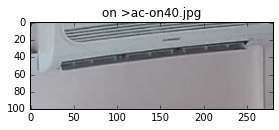

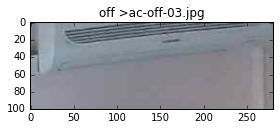

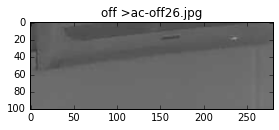

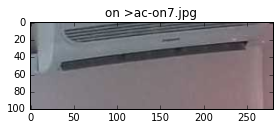

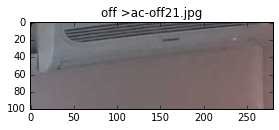

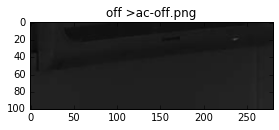

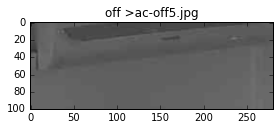

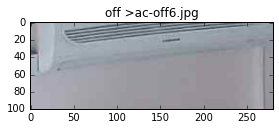

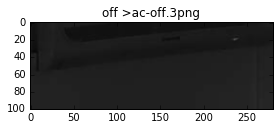

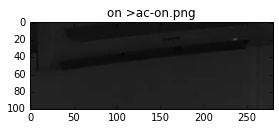

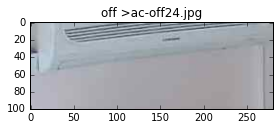

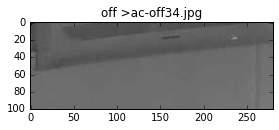

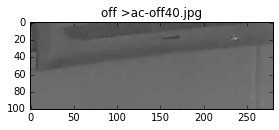

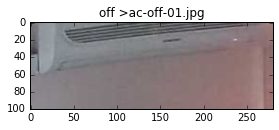

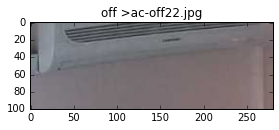

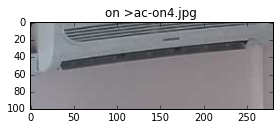

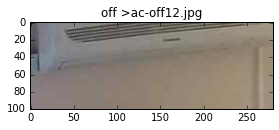

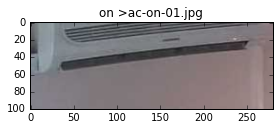

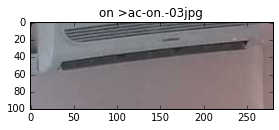

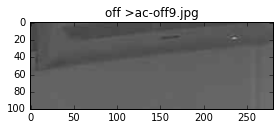

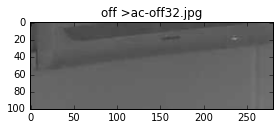

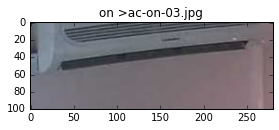

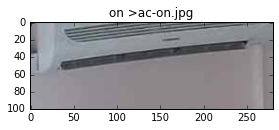

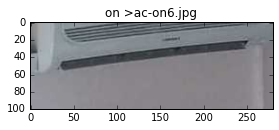

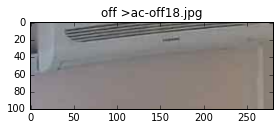

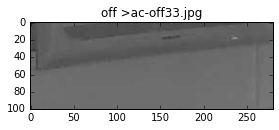

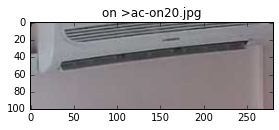

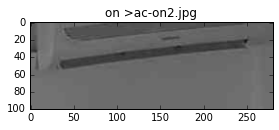

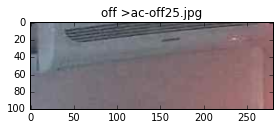

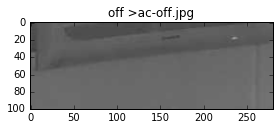

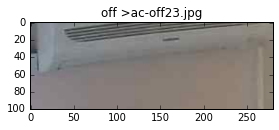

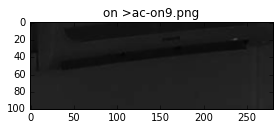

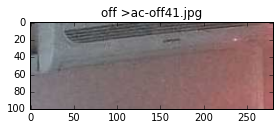

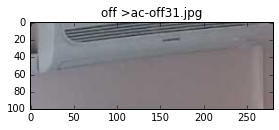

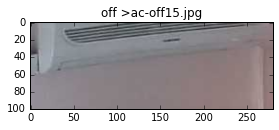

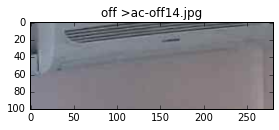

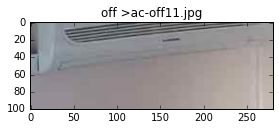

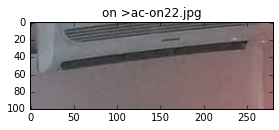

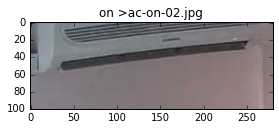

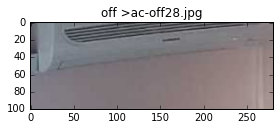

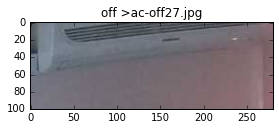

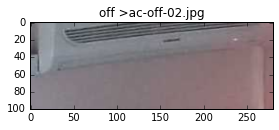

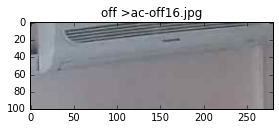

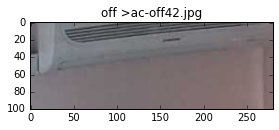

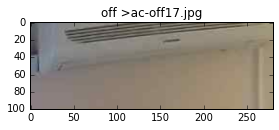

In [51]:
#predict(X_input2)
nn=0
n_plot=45

for x_idx in range(n_plot):
    nn=x_idx+0
    #print(nn,"->",fnames[nn])
    plt.figure(figsize=(20,20)) 
#    print('off' if y_classif0[nn][0]==1 else 'on')
#    dst_im = PredictByWholeImgFull(p_Xcolor=Xcolor,p_nn=nn)
#    dst_im_merge=MergePredict_Original(x_original[nn],dst_im)
    im_in=GetPicture(Xcolor,p_nn=nn,p_angle=0)
    sub1 = plt.subplot(1, 4,1)
    ll=ae_classif.predict(Xcolor[nn].reshape(1,Xcolor.shape[1],Xcolor.shape[2],Xcolor.shape[3]))
    #print (np.argmax(ll))
    dd='off' if np.argmax(ll)==1 else 'on'
    if g_colors==1:
        plt.imshow(im_in,  cmap='gray')
    else:
        plt.imshow(im_in)
    ##sub1.set_title("orig "+('on' if y_classif0[nn][0]==1 else 'off')+' is '+str(np.argmax(ll))+' >'+fnames[nn])
    sub1.set_title(dd+' >'+fnames[nn])

#    sub2 = plt.subplot(1, 4, 2)
#    if g_colors==1:
#        plt.imshow(y_region[nn].reshape(x_original[nn].shape[0],x_original[nn].shape[1]), cmap='gray')
#    else:
#        plt.imshow(y_region[nn]/256.)
#    sub2.set_title("learn")

#    sub3 = plt.subplot(1, 4, 3)
#    plt.imshow(dst_im, cmap='gray')
#    sub3.set_title("predict")
#    if  g_mode<2:
#        sub4 = plt.subplot(1, 4, 4)
#        plt.imshow(dst_im_merge)
#        sub4.set_title("merged")
#    plt.show()


In [ ]:
g_max_epochs=500
ae.fit(Xcolor, X_out)
pickle.dump(ae, open(fn_weight,'wb'))

from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [ ]:
ae = pickle.load(open(fn_weight,'rb'))
#pickle.dump(ae, open('conv_ae_medical400_class2.pkl','wb'))

In [ ]:
nn=1
n_plot=30

for x_idx in range(n_plot):
    nn=x_idx+0
    print(nn,"->",fnames[nn])
    plt.figure(figsize=(20,20)) 
    dst_im = PredictByWholeImgFull(p_Xcolor=Xcolor,p_nn=nn)
    dst_im_merge=MergePredict_Original(x_original[nn],dst_im)

    sub1 = plt.subplot(1, 4,1)
    if g_colors==1:
        plt.imshow( x_original[nn].reshape(x_original[nn].shape[0],x_original[nn].shape[1]), cmap='gray')
    else:
        plt.imshow( x_original[nn])
    sub1.set_title("orig")

    sub2 = plt.subplot(1, 4, 2)
    if g_colors==1:
        plt.imshow(y_region[nn].reshape(x_original[nn].shape[0],x_original[nn].shape[1]), cmap='gray')
    else:
        plt.imshow(y_region[nn]/256.)
    sub2.set_title("learn")

    sub3 = plt.subplot(1, 4, 3)
    plt.imshow(dst_im, cmap='gray')
    sub3.set_title("predict")
    if  g_mode<2:
        sub4 = plt.subplot(1, 4, 4)
        plt.imshow(dst_im_merge)
        sub4.set_title("merged")
    plt.show()



In [ ]:
from nolearn.lasagne import visualize
visualize.plot_conv_weights(ae.layers_['conv2D3'])

In [ ]:
lll=predictLayersToFile(p_net=ae,p_layerName='deconv2D2',p_Xcolor=Xcolor,p_nn=4,p_angle=0,N_epoch=1)
plt.imshow(lll,cmap='gray')

In [ ]:
lll=predictLayer(p_net=ae,p_layerName='deconv2D3',p_Xcolor=Xcolor,p_nn=1,p_angle=0,p_layerFrom=9,p_layers=1)
plt.imshow(lll,cmap='gray')

In [ ]:
plt.figure(figsize=(20,20)) 
print(x_original[nn].shape)
#v1=np.rollaxis(x_original[nn], 2, 0)
print(x_original[nn].shape)
v1=x_original[nn]
res=np.clip(zca_whitening_color(v1,epsilon = 0.01 )*256.,0,255).astype('uint8')
print(v1.shape)
v2=v1.reshape(v1.shape[0],v1.shape[1])
print(v2.shape)
sub4 = plt.subplot(1, 2, 1)
if g_colors==1:
    plt.imshow(v1.reshape(v1.shape[0],v1.shape[1]), cmap='gray')
else:
    plt.imshow(np.array(v1), cmap='gray')
sub4 = plt.subplot(1, 2, 2)
plt.imshow(res, cmap='gray')


In [ ]:
print_layers(ae)


In [ ]:
#e = pickle.load(open('conv_ae_medical224_7_BWIn.pkl','rb'))

In [ ]:
print(fnames )

In [ ]:
for x11, value in np.ndenumerate(fnames):
    if 'meta' in value:
         print ([x11[0],value])

In [ ]:
print (not not '1')

In [ ]:
a=[[1,2,4],[3,4,5]]
b=np.array(a)
print (b.shape)
print (b)

In [ ]:
a1=[[1],[3]]
b1=np.array(a1)

print (b1.shape)
print (b1)

In [ ]:
c1=b1
print (c1)
c1=np.hstack((c1,b1))
c1=np.hstack((c1,b1))
print (c1)

In [ ]:
l_widthF=850
p_width_from=0.5
p_width_delta=0.3
print(l_widthF-l_widthF*p_width_from)
print(l_widthF-l_widthF*p_width_from+l_widthF*p_width_delta)

In [ ]:
 plt.imshow(Image.open('conduk/ac-on6.jpg').crop((450,0,850,99)))

In [ ]:
d=np.zeros(10)

In [ ]:
d[8]=1

In [ ]:
d